In [2]:
import pandas as pd
import osmnx as ox
from shapely.geometry import Point
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import time
import os



OUTPUT_FILE = "Final_Dataset_With_Physical_Features.csv"

# OSMnx performance & logging settings
ox.settings.log_console = False
ox.settings.use_cache = True
ox.settings.requests_timeout = 30

PROGRESS_INTERVAL = 100


warnings.filterwarnings("ignore")


# Consolidated tag dictionary used for all spatial queries
FINAL_TAGS = {
    # Road network (major traffic contributors)
    "highway": ["motorway", "trunk", "primary", "secondary", "tertiary"],

    # Industrial activity indicators
    "landuse": [
        "industrial", "brownfield",
        "farmland", "farm", "orchard", "vineyard",
        "landfill"
    ],

    # Industrial infrastructure
    "man_made": ["chimney", "works", "tower"],

    # Waste-related facilities
    "amenity": [
        "waste_disposal",
        "waste_transfer_station",
        "recycling"
    ]
}


def fetch_osm_data(row):
    """
    For a given latitude/longitude:
    - Queries OSM features within 1.5 km
    - Computes minimum distance to:
        * Major roads
        * Industrial zones
        * Agricultural land
        * Dump / waste sites
    """
    data = row.copy()
    lat, lon = data["Latitude"], data["Longitude"]

    # Default distance values (used if no feature is found)
    data.update({
        "Dist_Road": 5000,
        "Dist_Industry": 5000,
        "Dist_Farm": 5000,
        "Dist_Dump": 5000
    })

    try:
        # Download nearby OSM features
        gdf = ox.features_from_point((lat, lon), tags=FINAL_TAGS, dist=1500)

        if gdf.empty:
            return data

        # Project to meters for accurate distance calculation
        gdf = gdf.to_crs(epsg=3857)
        center_point = ox.projection.project_geometry(
            Point(lon, lat), to_crs="epsg:3857"
        )[0]

        # ---------------- Roads ----------------
        roads = gdf[gdf["highway"].notna()]
        if not roads.empty:
            data["Dist_Road"] = round(roads.distance(center_point).min(), 2)

        # ---------------- Industry ----------------
        industry = gdf[
            gdf["landuse"].isin(["industrial", "brownfield"]) |
            gdf["man_made"].isin(["chimney", "works", "tower"])
        ]
        if not industry.empty:
            data["Dist_Industry"] = round(industry.distance(center_point).min(), 2)

        # ---------------- Agriculture ----------------
        farms = gdf[
            gdf["landuse"].isin(["farmland", "farm", "orchard", "vineyard"])
        ]
        if not farms.empty:
            data["Dist_Farm"] = round(farms.distance(center_point).min(), 2)

        # ---------------- Dump / Waste ----------------
        dumps = gdf[
            (gdf["landuse"] == "landfill") |
            gdf["amenity"].isin([
                "waste_disposal",
                "waste_transfer_station",
                "recycling"
            ])
        ]
        if not dumps.empty:
            data["Dist_Dump"] = round(dumps.distance(center_point).min(), 2)

    except Exception:
        # Fail silently to keep batch processing robust
        pass

    return data






In [3]:
CHECKPOINT_SIZE = 500   #  Save to disk every 500 locations

def main(input_df):
    print("\n--- Physical Feature Extraction Started ---")
    print(f"Total locations: {len(input_df)}")
    print("Batch size: 50 | Checkpoint save every 500 locations\n")

    records = input_df.to_dict("records")
    batch_size = 50
    total_processed = 0
    last_reported = 0
    buffer_results = []

    with ThreadPoolExecutor(max_workers=4) as executor:
        for batch_idx, i in enumerate(range(0, len(records), batch_size), start=1):
            batch = records[i:i + batch_size]

            batch_start = i + 1
            batch_end = min(i + batch_size, len(records))
            print(f" Starting batch {batch_idx}: locations {batch_start}–{batch_end}")

            futures = [executor.submit(fetch_osm_data, row) for row in batch]

            batch_results = []
            for future in as_completed(futures):
                try:
                    batch_results.append(future.result())
                except Exception:
                    pass

            buffer_results.extend(batch_results)
            total_processed += len(batch_results)

            print(f"Finished batch {batch_idx} ({len(batch_results)} locations)")

            #  Progress message every 100
            if total_processed - last_reported >= PROGRESS_INTERVAL:
                print(f" Total processed: {total_processed}/{len(input_df)}")
                last_reported = total_processed

            # Checkpoint save every 500 rows
            if len(buffer_results) >= CHECKPOINT_SIZE:
                print(f" Saving checkpoint ({len(buffer_results)} rows)...")

                buffer_df = pd.DataFrame(buffer_results)
                buffer_df.to_csv(
                    OUTPUT_FILE,
                    mode="a",
                    index=False,
                    header=not os.path.exists(OUTPUT_FILE)
                )
                buffer_results.clear()

            time.sleep(1)

    # 🔹 Final flush (remaining rows < 500)
    if buffer_results:
        print(f" Final save ({len(buffer_results)} rows)...")
        buffer_df = pd.DataFrame(buffer_results)
        buffer_df.to_csv(
            OUTPUT_FILE,
            mode="a",
            index=False,
            header=not os.path.exists(OUTPUT_FILE)
        )

    print(f"\n--- DONE! All {total_processed} locations processed successfully ---")


In [4]:
if __name__ == "__main__":
    df = pd.read_csv("Pollution_Weather_ten_countries.csv")
    main(df)


--- Physical Feature Extraction Started ---
Total locations: 2495
Batch size: 50 | Checkpoint save every 500 locations

 Starting batch 1: locations 1–50
Finished batch 1 (50 locations)
 Starting batch 2: locations 51–100
Finished batch 2 (50 locations)
 Total processed: 100/2495
 Starting batch 3: locations 101–150
Finished batch 3 (50 locations)
 Starting batch 4: locations 151–200
Finished batch 4 (50 locations)
 Total processed: 200/2495
 Starting batch 5: locations 201–250
Finished batch 5 (50 locations)
 Starting batch 6: locations 251–300
Finished batch 6 (50 locations)
 Total processed: 300/2495
 Starting batch 7: locations 301–350
Finished batch 7 (50 locations)
 Starting batch 8: locations 351–400
Finished batch 8 (50 locations)
 Total processed: 400/2495
 Starting batch 9: locations 401–450
Finished batch 9 (50 locations)
 Starting batch 10: locations 451–500
Finished batch 10 (50 locations)
 Total processed: 500/2495
 Saving checkpoint (500 rows)...
 Starting batch 11: loc

In [2]:
import pandas as pd
df = pd.read_csv(r"C:\Users\kalin\EnviroScan\Batch-6\Datasets\EnviroScan_Final_2495.csv")
df.head()

,Country,City,Location_Type,Latitude,Longitude,AQI,PM2_5,NO2,SO2,O3,CO,PM10,Temperature,Humidity,Wind_Speed,Weather_Condition,Dist_Road,Dist_Industry,Dist_Farm,Dist_Dump
0,India,New Delhi,Sector_2,28.643660,77.210440,5.0,193.81,33.51,5.47,51.45,1021.91,251.83,16.05,72,2.06,Haze,137.20,706.00,5000.0,2223.79
1,India,New Delhi,Sector_3,28.610620,77.221930,5.0,193.81,33.51,5.47,51.45,1021.91,251.83,16.08,72,2.06,Haze,67.03,5000.00,5000.0,5000.00
2,India,New Delhi,City Center,28.613895,77.209006,5.0,193.81,33.51,5.47,51.45,1021.91,251.83,17.07,67,2.06,Haze,1.72,5000.00,5000.0,5000.00
3,India,New Delhi,Sector_1,28.636830,77.208480,5.0,193.81,33.51,5.47,51.45,1021.91,251.83,16.05,72,2.06,Haze,149.10,334.58,5000.0,5000.00
4,India,Mumbai,Sector_2,19.095230,72.861060,5.0,165.97,2.71,25.78,215.48,614.03,183.41,28.97,42,2.57,Smoke,530.78,369.93,5000.0,5000.00


In [7]:
df.shape

(2645, 20)

In [8]:
df.describe()

,Latitude,Longitude,AQI,PM2_5,NO2,SO2,O3,CO,PM10,Temperature,Humidity,Wind_Speed,Dist_Road,Dist_Industry,Dist_Farm,Dist_Dump
count,2645.000000,2645.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2645.000000,2645.00000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000
mean,23.592930,41.508748,3.052950,87.501418,15.012303,7.488154,59.778253,545.632912,120.524433,15.978008,63.52741,2.619456,558.149308,2837.219905,4335.137905,3826.737592
std,21.443374,65.811642,1.757594,106.463395,22.106133,19.790829,40.637813,576.365411,152.034679,11.815622,25.80228,1.570882,1108.462463,2229.392970,1486.255919,1903.231195
min,-30.048670,-122.730440,1.000000,0.500000,0.040000,0.000000,0.000000,57.290000,0.500000,-27.690000,10.00000,0.000000,0.000000,0.000000,0.000000,20.840000
25%,8.508070,6.911000,1.000000,4.930000,1.387500,0.440000,33.982500,169.690000,8.320000,7.880000,46.00000,1.540000,64.600000,502.790000,5000.000000,1607.890000
50%,25.526388,72.070570,3.000000,27.040000,7.640000,2.120000,52.060000,298.580000,34.570000,18.990000,67.00000,2.460000,164.590000,5000.000000,5000.000000,5000.000000
75%,37.350610,89.652980,5.000000,155.557500,18.170000,6.217500,78.070000,719.030000,202.970000,24.510000,86.00000,3.280000,466.050000,5000.000000,5000.000000,5000.000000
max,64.580520,140.717590,5.000000,417.200000,155.810000,510.090000,225.290000,5339.640000,791.050000,35.840000,100.00000,10.290000,5000.000000,5000.000000,5000.000000,5000.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            2645 non-null   object 
 1   City               2645 non-null   object 
 2   Location_Type      2645 non-null   object 
 3   Latitude           2645 non-null   float64
 4   Longitude          2645 non-null   float64
 5   AQI                2644 non-null   float64
 6   PM2_5              2644 non-null   float64
 7   NO2                2644 non-null   float64
 8   SO2                2644 non-null   float64
 9   O3                 2644 non-null   float64
 10  CO                 2644 non-null   float64
 11  PM10               2644 non-null   float64
 12  Temperature        2645 non-null   float64
 13  Humidity           2645 non-null   int64  
 14  Wind_Speed         2645 non-null   float64
 15  Weather_Condition  2645 non-null   object 
 16  Dist_Road          2645 

In [10]:
df.isnull().sum()


Country              0
City                 0
Location_Type        0
Latitude             0
Longitude            0
AQI                  1
PM2_5                1
NO2                  1
SO2                  1
O3                   1
CO                   1
PM10                 1
Temperature          0
Humidity             0
Wind_Speed           0
Weather_Condition    0
Dist_Road            0
Dist_Industry        0
Dist_Farm            0
Dist_Dump            0
dtype: int64

In [3]:
df = df.dropna(subset=['AQI'])

In [12]:
df.shape

(2644, 20)

In [4]:
df = df.drop_duplicates()

In [7]:
df.shape

(2494, 20)

In [16]:
df.to_csv("EnviroScan_Final_2495.csv", index=False)

In [5]:
(df['Dist_Farm']>2000).sum()

np.int64(2122)

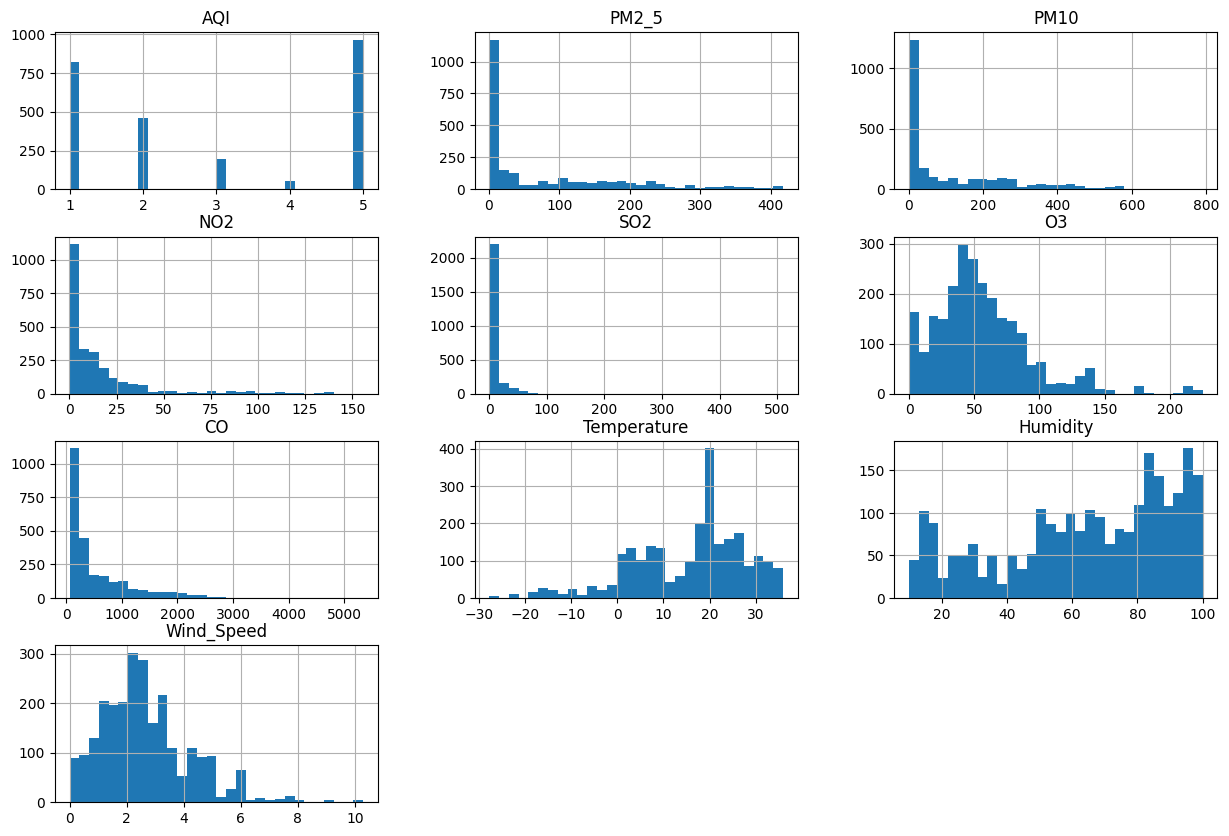

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# histogram distribution
numeric_cols = ['AQI', 'PM2_5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 'Temperature', 'Humidity', 'Wind_Speed']
df[numeric_cols].hist(bins=30, figsize=(15,10))
plt.show()

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


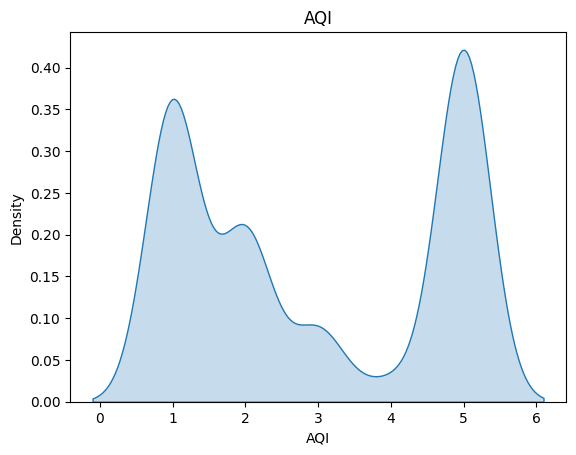

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


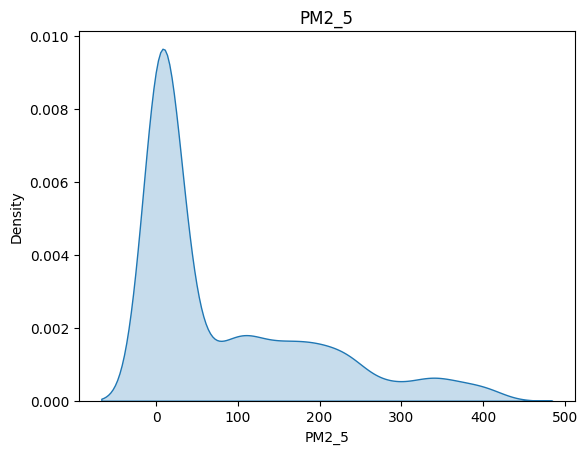

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


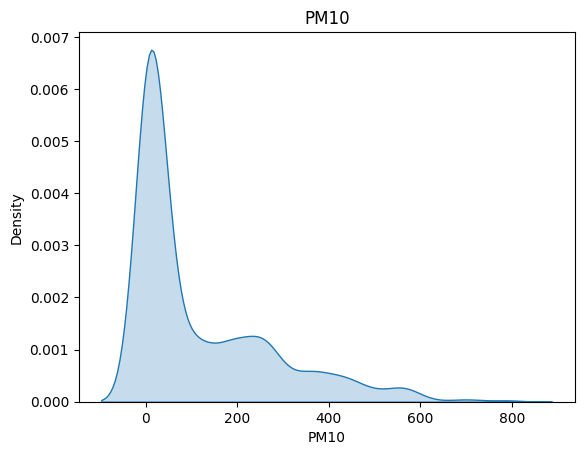

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


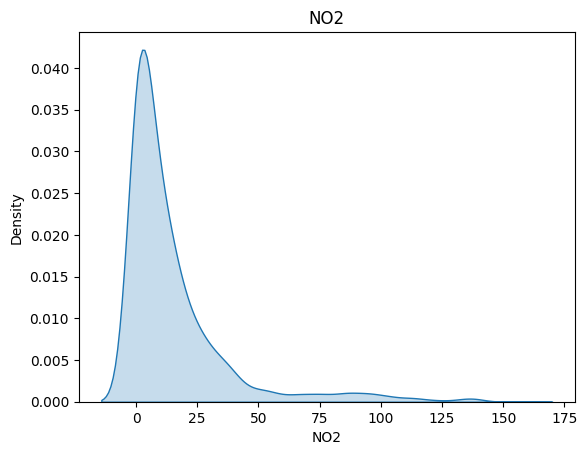

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


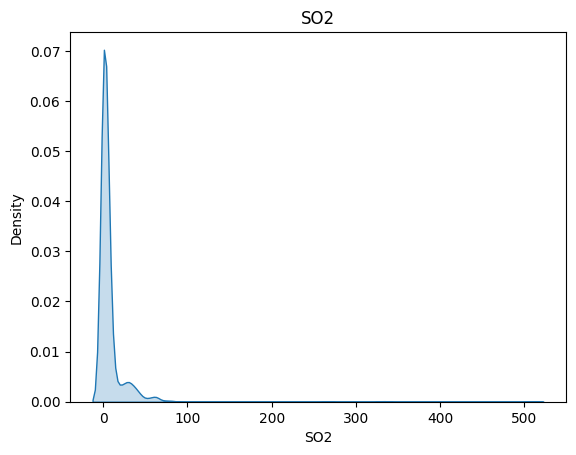

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


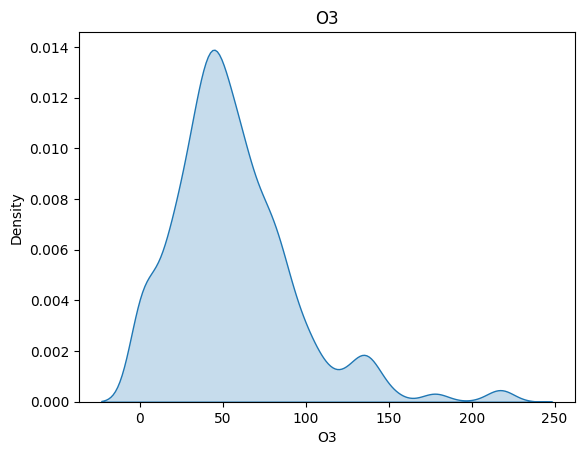

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


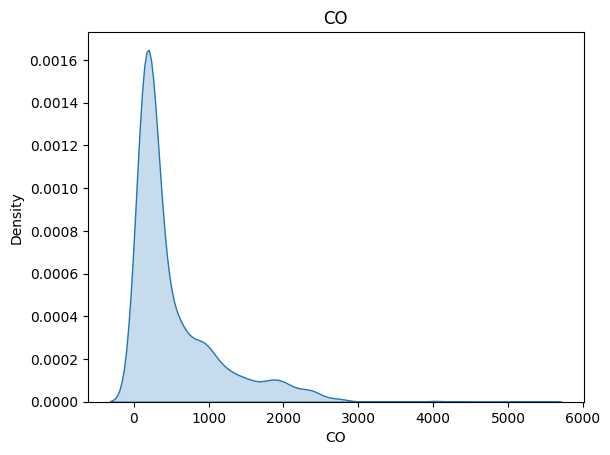

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


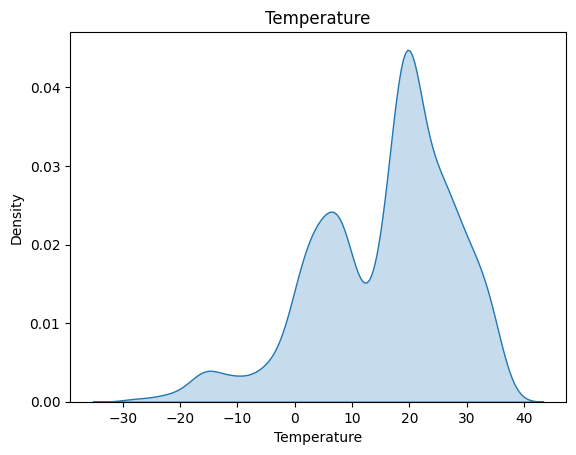

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


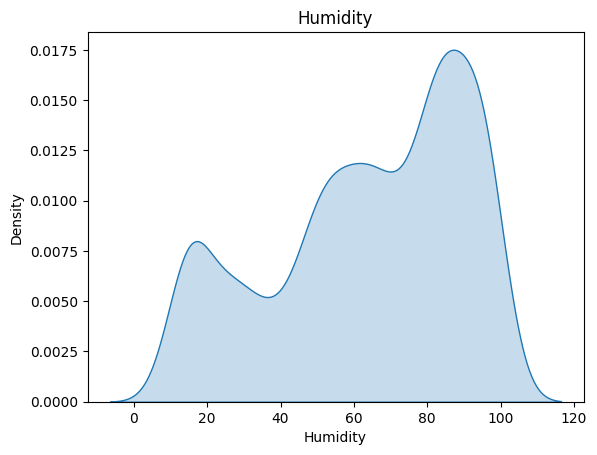

C:\Users\kalin\AppData\Local\Temp\ipykernel_16244\4049634137.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True)


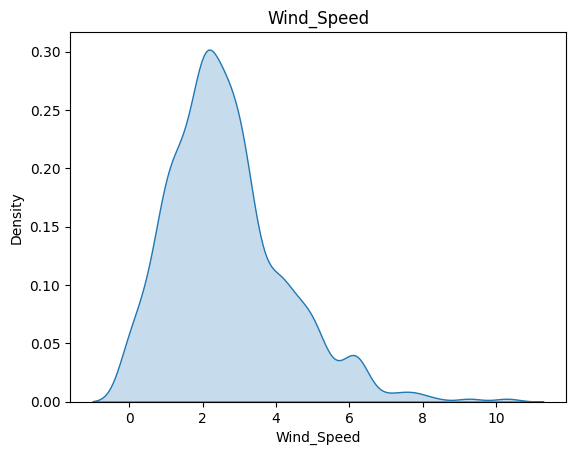

In [10]:
for col in numeric_cols:
    sns.kdeplot(df[col], shade=True)
    plt.title(col)
    plt.show()

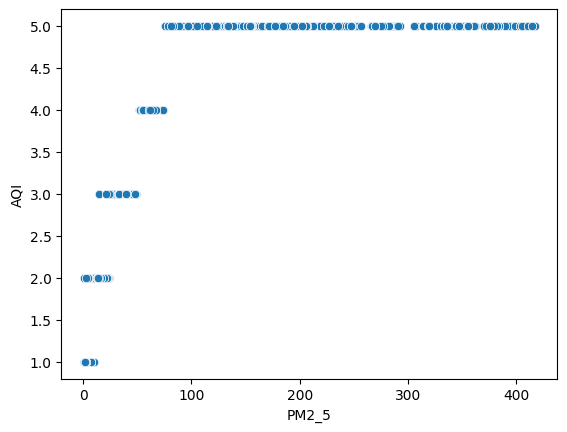

In [11]:
sns.scatterplot(x='PM2_5', y='AQI', data=df)

plt.show()

<Axes: xlabel='PM10', ylabel='AQI'>

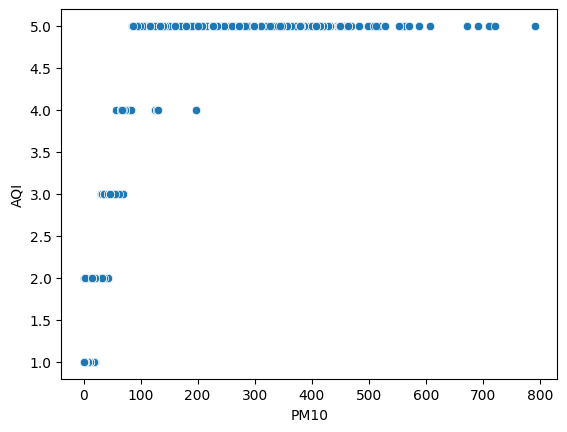

In [12]:
sns.scatterplot(x='PM10', y='AQI', data=df)

<Axes: xlabel='O3', ylabel='AQI'>

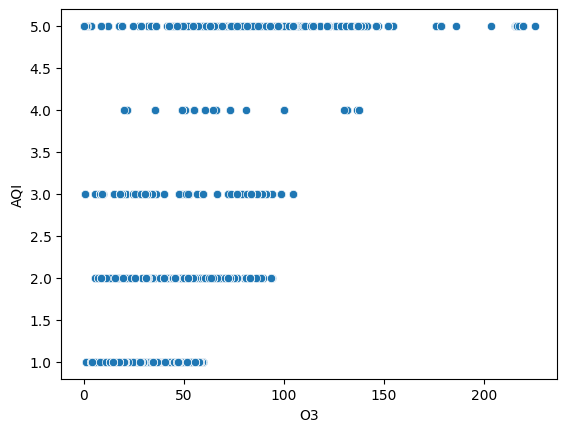

In [13]:
sns.scatterplot(x='O3', y='AQI', data=df)

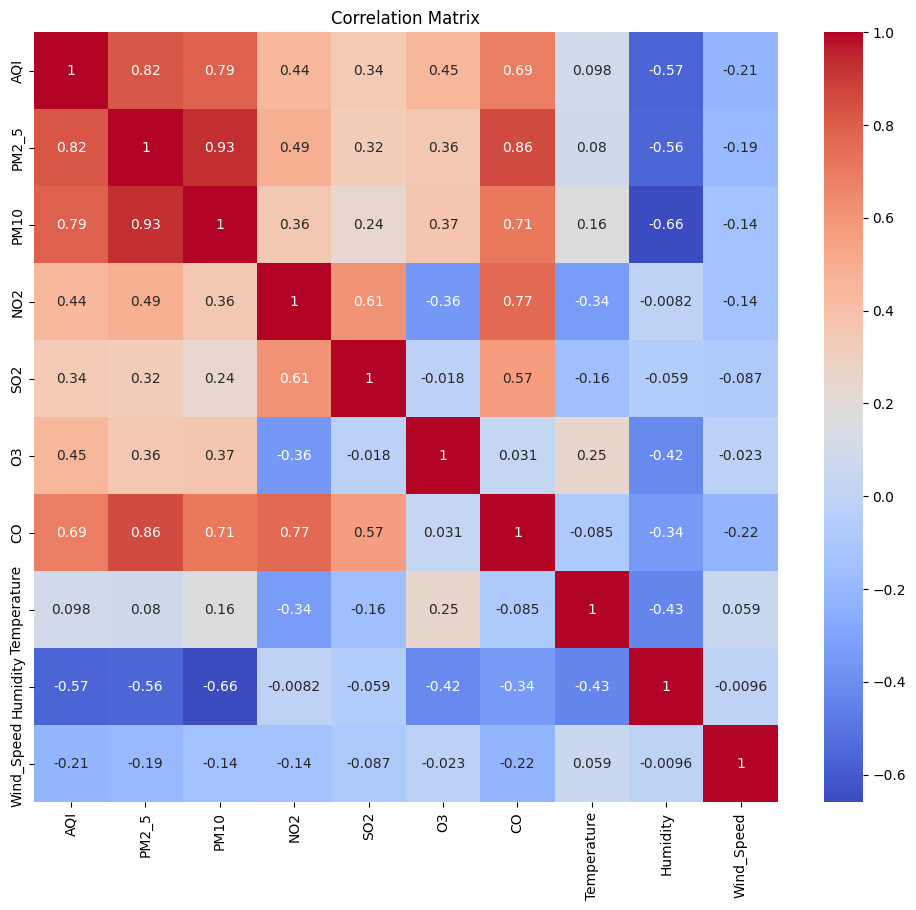

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
